In [ ]:
#default_exp interpret.gradcam

# GradCam

> Produce heatmaps to interpret your models

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
#hide
import fastai
print(fastai.__version__)

2.0.16


In [ ]:
#export
from fastai.vision.all import *
from typing import List, Tuple, Callable, Union, Optional, Any

In [ ]:
#hide
from cinemanet.train.data_handler import *

learn = load_learner("../framing-1.pkl")
learn.model[1] = nn.Sequential(*[learn.model[0][-1], *learn.model[1]])
learn.model[0][-1] = Identity()

dhandler = (
    DataHandler("../../CinemaNet-Training/exports/datasets/shot-framing.json",
                is_multilabel=False, verbose=False)
    .get_dataset_df('train-clean', 'valid-clean')
    .filter_dataset()
    .setup_dls(batch_size=32)
)

learn.dls = dhandler.dls

/home/synopsis/git/CinemaNet-Training/cinemanet/train/data_handler.py:306: UserWarning: No batch transforms have been passed. Training with NO data augmentation
  warnings.warn("No batch transforms have been passed. Training with NO data augmentation")


In [ ]:
#hide
torch.cuda.set_device(0)
torch.cuda.get_device_name()

'GeForce RTX 3090'

<h3> Steps for plotting GradCAM </h3>

<br>

1. Create your `Learner`'s `test_dl` w.r.t. one image and label
2. Compute activations (forward pass) and gradients (backward pass)
3. Compute gradcam-map (7x7 in this case)
    1. Take mean of gradients across feature maps: `(1280, 7, 7) --> (1280, 1, 1)`
    2. Multiply mean * activation: `(1280,1,1) * (1280,7,7) --> (1280,7,7)`
    3. Sum of (B): `(1280,7,7) --> (7,7)`
4. Plot gradcam-map over the image

In [ ]:
#export
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, inp, out):  self.stored = out.detach().clone()
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.hook.remove()

class HookBwd():
    def __init__(self,m):
        self.hook = m.register_backward_hook(self.hook_func)
    def hook_func(self, model, grad_in, grad_out): self.stored = grad_out[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.hook.remove()

#### 1. Create your `Learner`'s `test_dl` w.r.t. one image and label

In [ ]:
path_imgs = '../assets/imgs/'
f = get_image_files(path_imgs)[2]

img = PILImage.create(f)
x   = first(learn.dls.test_dl([f]))
x   = x[0] # get image from tuple of len == 1

In [ ]:
#export
def create_test_img(learn, f, return_img=True):
    img = PILImage.create(f)
    x = first(learn.dls.test_dl([f]))
    x = x[0]
    if return_img: return img,x
    return x

In [ ]:
img,x = create_test_img(learn, f)
label = np.random.choice(learn.dls.vocab)
label

'03-long'

#### 2. Compute activations (forward pass) and gradients (backward pass)

In [ ]:
#export
def to_cuda(*args): [o.cuda() for o in args]
def get_label_idx(learn:Learner, preds:torch.Tensor,
                  label:Union[str,int,None]) -> Tuple[int,str]:
    """Either:
    * Get the label idx of a specific `label`
    * Get the max pred using `learn.loss_func.decode` and `learn.loss_func.activation`
        * Only works for `softmax` activations as the backward pass requires a scalar index
        * Throws a `RuntimeError` if the activation is a `sigmoid` activation
    """
    if label is not None:
        # if `label` is a string, check that it exists in the vocab
        # and return the label's index
        if isinstance(label,str):
            if not label in learn.dls.vocab: raise ValueError(f"'{label}' is not part of the Learner's vocab: {learn.dls.vocab}")
            return learn.dls.vocab.o2i[label], label
        # if `label` is an index, return itself
        elif isinstance(label,int): return label, learn.dls.vocab[label]
        else: raise TypeError(f"Expected `str`, `int` or `None`, got {type(label)} instead")
    else:
        # if no `label` is specified, check that `learn.loss_func` has `decodes`
        # and `activation` implemented, run the predictions through them,
        # then check that the output length is 1. If not, the activation must be
        # sigmoid, which is incompatible
        if not hasattr(learn.loss_func, 'activation') or\
           not hasattr(learn.loss_func, 'decodes'):
            raise NotImplementedError(f"learn.loss_func does not have `.activation` or `.decodes` methods implemented")
        decode_pred = compose(learn.loss_func.activation, learn.loss_func.decodes)
        label_idx   = decode_pred(preds)
        if len(label_idx) > 1:
            raise RuntimeError(f"Output label idx must be of length==1. If your loss func has a sigmoid activation, please specify `label`")
        return label_idx, learn.dls.vocab[label_idx][0]

def get_target_layer(learn: Learner,
                     target_layer:Union[nn.Module, Callable, None]) -> nn.Module:
    if target_layer is None:
        if has_pool_type(learn.model[0]):
            warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")  
        return learn.model[0]
    elif isinstance(target_layer, nn.Module):
        return target_layer
    elif callable(target_layer):
        return target_layer(learn.model)
    
def compute_gcam_items(learn: Learner,
                       x: TensorImage,
                       label: Union[str,int,None] = None,
                       target_layer: Union[nn.Module, Callable, None] = None
                      ) -> Tuple[torch.Tensor]:
    """Compute gradient and activations of `target_layer` of `learn.model`
    for `x` with respect to `label`.
    
    If `target_layer` is None, then it is set to `learn.model[:-1]`
    """
    to_cuda(learn.model, x)
    target_layer = get_target_layer(learn, target_layer)
    with HookBwd(target_layer) as hook_g:
        with Hook(target_layer) as hook:
            preds       = learn.model.eval()(x)
            activations = hook.stored
            label_idx, label = get_label_idx(learn,preds,label)
            #print(preds.shape, label, label_idx)
            #print(preds)
        preds[0, label_idx].backward()
        gradients = hook_g.stored

    preds = getattr(learn.loss_func, 'activation', noop)(preds)

    # remove leading batch_size axis
    gradients   = gradients  [0]
    activations = activations[0]
    preds       = preds.detach().cpu().numpy().flatten()
    return gradients, activations, preds, label

In [ ]:
gradients, activations, preds, label = compute_gcam_items(learn, x, label=None, target_layer=None)

gradients.shape, activations.shape, preds.shape, label

(torch.Size([1280, 7, 7]), (1280, 7, 7), (9,), '04-medium-long')

#### 3. Compute gradcam-map

In [ ]:
#export
def compute_gcam_map(gradients, activations) -> torch.Tensor:
    """Take the mean of `gradients`, multiply by `activations`,
    sum it up and return a GradCAM feature map
    """
    # Mean over the feature maps. If you don't use `keepdim`, it returns
    # a value of shape (1280) which isn't amenable to `*` with the activations
    gcam_weights = gradients.mean(dim=[1,2], keepdim=True) # (1280,7,7)   --> (1280,1,1)
    gcam_map     = (gcam_weights * activations) # (1280,1,1) * (1280,7,7) --> (1280,7,7)
    gcam_map     = gcam_map.sum(0)              # (1280,7,7) --> (7,7)
    return gcam_map

In [ ]:
gcam_map = compute_gcam_map(gradients, activations)
gcam_map.shape

(7, 7)

#### 4. Plot gradcam-map over the image

<AxesSubplot:>

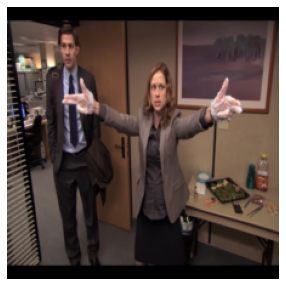

In [ ]:
TensorImage(learn.dls.train.decode((x,))[0][0]).show()

In [ ]:
#export
import PIL
def plt2pil(fig) -> PIL.Image.Image:
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    pil_img = PIL.Image.open(buf).convert('RGB')
    plt.close('all')
    return pil_img

def plt_decoded(learn, x, ctx):
    'Processed tensor --> plottable image, return `extent`'
    x_decoded = TensorImage(learn.dls.train.decode((x,))[0][0])
    extent = (0, x_decoded.shape[1], x_decoded.shape[2], 0)
    x_decoded.show(ctx=ctx)
    return extent
    
def plot_gcam(img:PILImage, x:tensor, gcam_map:tensor, plt_axis=None,
              full_size=True, alpha=0.6, learn=None, dpi=100,
              interpolation='bilinear', cmap='magma', **kwargs):
    'Plot gradcam on `plt_axis`'
    fig,ax = plt.subplots(dpi=dpi, **kwargs)
    if full_size:
        extent = (0, img.width,img.height, 0)
        show_image(img, ctx=ax)
    else:
        extent = plt_decoded(learn, x, ax)#plt_axis)

    show_image(gcam_map.detach().cpu(), ctx=ax,
               alpha=alpha, extent=extent,
               interpolation=interpolation, cmap=cmap)
    
    return plt2pil(fig)
#     buf = io.BytesIO()
#     fig.savefig(buf, bbox_inches='tight', pad_inches=0)
#     buf.seek(0)
#     pil_img = PIL.Image.open(buf).convert('RGB')
#     plt.close('all')
#     return pil_img

In [ ]:
PIL.Image.open(f).shape

(1600, 2560)

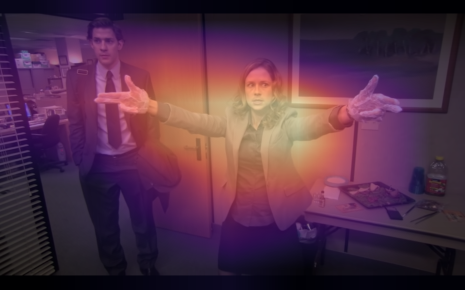

In [ ]:
#fig,ax = plt.subplots()
plot_gcam(img, x, gcam_map, full_size=True, dpi=100)

In [ ]:
@patch
@delegates(to=plot_gcam_maps, but=["learn", "labels", "_label", "img", "x", "preds_dict", "gcams"])
def gradcam(self: Learner,
            item: Union[PILImage, os.PathLike],
            target_layer: Union[nn.Module, Callable, None] = None,
            labels: Union[str,List[str], int,List[int], None] = None,
            **kwargs
           ):
    dl = self.dls.test_dl([item])
    x = detuplify(first(dl))
    
    gcams = defaultdict()
    if not isinstance(labels, list): labels=[labels]
    for label in labels:
        grads, acts, preds, _label = compute_gcam_items(self, x, label, target_layer)
        gcams[label] = compute_gcam_map(grads, acts)
        preds_dict = {l:pred for pred,l in zip(preds, self.dls.vocab)}
    
    img = PILImage.create(item)
    return plot_gcam_maps(self, labels, _label, img, x, preds_dict, gcams, **kwargs)
    #return x

In [ ]:
#export
from typing import Dict
def plot_gcam_maps(
    learn:Learner, labels:List[str], _label:str, img:PILImage, x:TensorImage,
    preds_dict:Dict[str,float], gradcams:Dict[str,torch.Tensor],
    ## plotting args
    max_ncols=None, full_size=True, alpha=0.6,
    interpolation='bilinear', cmap='magma',
    figsize=(12,12), return_fig=False, plot_original=False
):
    """
    Plot the computed Grad-CAMs.

    Key Arguments
    -------------
    * full_size: If True, plots the images in their original size, else
                 in the size that the `Learner` resizes them to
    * plot_original: if True, plots the original image without any overlays
                     in addition to the heatmaps
    * max_ncols: Use this to manipulate the number of rows you'd like your
                 plot to have. Useful for classifiers with a large no. of
                 outputs. Enter `None` to plot everything in one row.
    """
    label_idx = 0
    total = len(labels)+1 if plot_original else len(labels)

    if max_ncols is None:
        max_ncols=len(labels)+1 if plot_original else len(labels)

    if total > max_ncols:
        nrows  = math.ceil(total/max_ncols)
        fig,ax = plt.subplots(nrows=nrows, ncols=max_ncols, figsize=figsize)
        plt.axis('off')
        plt.tight_layout()

        for i in range(nrows):
            for j in range(max_ncols):
                if plot_original:
                    if i==0 and j==0:
                        if full_size:
                            show_image(img, ctx=ax[0,0])
                        else:
                            x = TensorImage(learn.dls.train.decode((x,))[0][0])
                            x.show(ctx=ax[0,0])
                        ax[0][0].set_title('original')
                        continue
                plot_gcam(img=img, x=x, full_size=full_size,
                          gcam_map=gradcams[labels[label_idx]],
                          plt_axis=ax[i,j], alpha=alpha, learn=learn,
                          interpolation=interpolation, cmap=cmap)
                title = labels[label_idx]
                ax[i][j].set_title(f'{title}, {preds_dict[title] * 100:.02f}%')
                label_idx += 1
                if label_idx >= len(labels): break
    else:
        fig,ax = plt.subplots(nrows=1, ncols=max_ncols, figsize=figsize)
        plt.axis('off')
        plt.tight_layout()
        
        if max_ncols==1: ax=[ax]
        for i in range(len(ax)):
            if plot_original:
                if i==0 and full_size:
                    show_image(img, ctx=ax[0])
                    ax[0].set_title('original')
                    continue
                elif i==0 and not full_size:
                    _ = plt_decoded(learn, x, ctx=ax[0])
                    ax[0].set_title('original')
                    continue
            plot_gcam(img=img, x=x, full_size=full_size,
                      gcam_map=gradcams[labels[label_idx]],
                      plt_axis=ax[i], alpha=alpha, learn=learn,
                      interpolation=interpolation, cmap=cmap) 
            title = labels[label_idx]
            if title is None: title=_label
            ax[i].set_title(f'{title}, {preds_dict[title] * 100:.02f}%')
            label_idx += 1

### Class interface for computing multiple Grad-CAMs for one image

In [ ]:
@patch
@delegates(to=plot_gcam_maps, but=["learn", "labels", "_label", "img", "x", "preds_dict", "gcams"])
def gradcam(self: Learner,
            item: Union[PILImage, os.PathLike],
            target_layer: Union[nn.Module, Callable, None] = None,
            labels: Union[str,List[str], int,List[int], None] = None,
            **kwargs
           ):
    dl = self.dls.test_dl([item])
    x = detuplify(first(dl))
    
    gcams = defaultdict()
    if not isinstance(labels, list): labels=[labels]
    for label in labels:
        grads, acts, preds, _label = compute_gcam_items(self, x, label, target_layer)
        gcams[label] = compute_gcam_map(grads, acts)
        preds_dict = {l:pred for pred,l in zip(preds, self.dls.vocab)}
    
    img = PILImage.create(item)
    return plot_gcam_maps(self, labels, _label, img, x, preds_dict, gcams, **kwargs)
    #return x

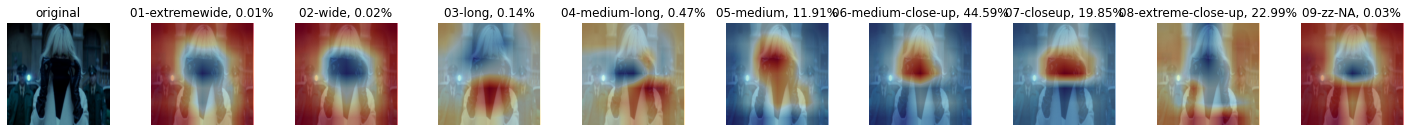

In [ ]:
learn.gradcam("../assets/imgs/atomic-blonde.jpg", labels=list(learn.dls.vocab),
              full_size=False, plot_original=True, figsize=(20,10),
              cmap=RdYlBu_10_r.mpl_colormap
             )

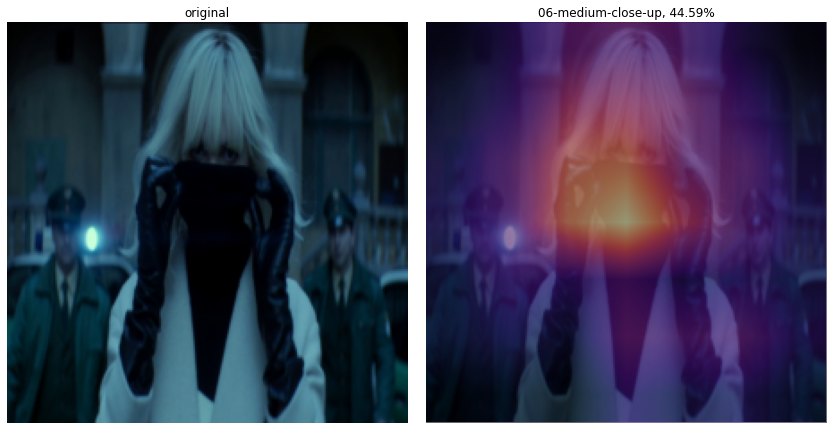

In [ ]:
from palettable.colorbrewer.diverging import *

learn.gradcam("../assets/imgs/atomic-blonde.jpg", labels=None,
              full_size=False, plot_original=True,
              #cmap=PuOr_4_r.mpl_colormap
              cmap="magma"
             )

In [ ]:
#export
import math
from typing import List
PathLike = Union[str,Path]

class GradCam():
    "Class interface to facilitate computing and siplaying Grad-CAM"
    def __init__(self, learn:Learner, fname:PathLike, labels:Union[str,List[str],None]):
        """
        Compute Grad-CAM maps for all `labels`.
        If `labels` is None, compute for the predicted class (more expensive)
        """
        self.learn = learn
        self.fname = fname
        self.img, self.x = create_test_img(self.learn, self.fname)
        if labels is None:
            self.labels = [self.learn.predict(fname)[0]]
        else:
            self.labels = [labels] if isinstance(labels,str) else labels
        self.compute_gcams()
    
    def compute_gcams(self):
        self.gradcams = defaultdict()
        for label in self.labels:
            gradients, activations, self.preds = compute_gcam_items(self.learn,self.x,label)
            gcam_map = compute_gcam_map(gradients, activations)
            self.gradcams[label] = gcam_map
            self.preds_dict = {
                lab:pred for pred,lab in zip(self.preds, self.learn.dls.vocab)
            }
    
    def plot(self, max_ncols=None, full_size=True, alpha=0.6,
             interpolation='bilinear', cmap='magma',
             figsize=(12,12), return_fig=False, plot_original=False):
        """
        Plot the computed Grad-CAMs.
        
        Key Arguments
        -------------
        * full_size: If True, plots the images in their original size, else
                     in the size that the `Learner` resizes them to
        * plot_original: if True, plots the original image without any overlays
                         in addition to the heatmaps
        * max_ncols: Use this to manipulate the number of rows you'd like your
                     plot to have. Useful for classifiers with a large no. of
                     outputs. Enter `None` to plot everything in one row.
        """
        label_idx = 0
        total = len(self.labels)+1 if plot_original else len(self.labels)
        
        if max_ncols is None:
            max_ncols=len(self.labels)+1 if plot_original else len(self.labels)
        
        if total > max_ncols:
            nrows  = math.ceil(total/max_ncols)
            fig,ax = plt.subplots(nrows=nrows, ncols=max_ncols, figsize=figsize)
            plt.axis('off')
            
            for i in range(nrows):
                for j in range(max_ncols):
                    if plot_original:
                        if i==0 and j==0:
                            if full_size:
                                show_image(self.img, ctx=ax[0,0])
                            else:
                                x = TensorImage(learn.dls.train.decode((self.x,))[0][0])
                                x.show(ctx=ax[0,0])
                            ax[0][0].set_title('original')
                            continue
                    plot_gcam(img=self.img, x=self.x, full_size=full_size,
                              gcam_map=self.gradcams[self.labels[label_idx]],
                              plt_axis=ax[i,j], alpha=alpha, learn=self.learn,
                              interpolation=interpolation, cmap=cmap)
                    title = self.labels[label_idx]
                    ax[i][j].set_title(f'{title}, {self.preds_dict[title] * 100:.02f}%')
                    label_idx += 1
                    if label_idx >= len(self.labels): break
        else:
            fig,ax = plt.subplots(nrows=1, ncols=max_ncols, figsize=figsize)
            plt.axis('off')
            
            for i in range(len(ax)):
                if plot_original:
                    if i==0 and full_size:
                        show_image(self.img, ctx=ax[0])
                        ax[0].set_title('original')
                        continue
                    elif i==0 and not full_size:
                        _ = plt_decoded(self.learn, self.x, ctx=ax[0])
                        ax[0].set_title('original')
                        continue
                plot_gcam(img=self.img, x=self.x, full_size=full_size,
                          gcam_map=self.gradcams[self.labels[label_idx]],
                          plt_axis=ax[i], alpha=alpha, learn=self.learn,
                          interpolation=interpolation, cmap=cmap) 
                title = self.labels[label_idx]
                ax[i].set_title(f'{title}, {self.preds_dict[title] * 100:.02f}%')
                label_idx += 1

In [ ]:
f = get_image_files(path_imgs)[0]

In [ ]:
#hide
from nbdev.showdoc import show_doc
show_doc(GradCam.__init__)

<h4 id="GradCam.__init__" class="doc_header"><code>GradCam.__init__</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>GradCam.__init__</code>(**`learn`**:`Learner`, **`fname`**:`Union`\[`str`, `Path`\], **`labels`**:`Union`\[`str`, `List`\[`str`\], `NoneType`\])

```
Compute Grad-CAM maps for all `labels`.
If `labels` is None, compute for the predicted class (more expensive)
```

A `GradCAM` object can be initialised, passing in a `Learner` and as many `labels` as you'd like to compute the GradCAM heatmaps for. <br>
The GradCAM tensors can be accessed via `GradCAM.gradcams` which is a dictionary whose keys are the `labels` you pass in

In [ ]:
learn.dls.vocab

(#9) ['01-extremewide','02-wide','03-long','04-medium-long','05-medium','06-medium-close-up','07-closeup','08-extreme-close-up','09-zz-NA']

In [ ]:
gcam = GradCam(learn, f, labels=['01-extremewide', '07-closeup', '08-extreme-close-up'])

In [ ]:
{k:v.shape for k,v in gcam.gradcams.items()}

{'01-extremewide': (7, 7), '02-wide': (7, 7), '07-closeup': (7, 7)}

In [ ]:
show_doc(GradCam.plot)

<h4 id="GradCam.plot" class="doc_header"><code>GradCam.plot</code><a href="__main__.py#L32" class="source_link" style="float:right">[source]</a></h4>

> <code>GradCam.plot</code>(**`max_ncols`**=*`None`*, **`full_size`**=*`True`*, **`alpha`**=*`0.6`*, **`interpolation`**=*`'bilinear'`*, **`cmap`**=*`'magma'`*, **`figsize`**=*`(12, 12)`*, **`return_fig`**=*`False`*, **`plot_original`**=*`False`*)

```
Plot the computed Grad-CAMs.

Key Arguments
-------------
* full_size: If True, plots the images in their original size, else
             in the size that the `Learner` resizes them to
* plot_original: if True, plots the original image without any overlays
                 in addition to the heatmaps
* max_ncols: Use this to manipulate the number of rows you'd like your
             plot to have. Useful for classifiers with a large no. of
             outputs. Enter `None` to plot everything in one row.
```

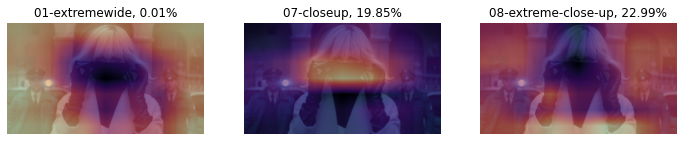

In [ ]:
gcam.plot()

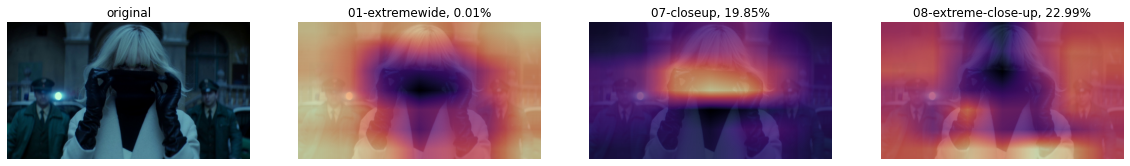

In [ ]:
gcam.plot(full_size=True, plot_original=True, figsize=(20,4), alpha=0.75)

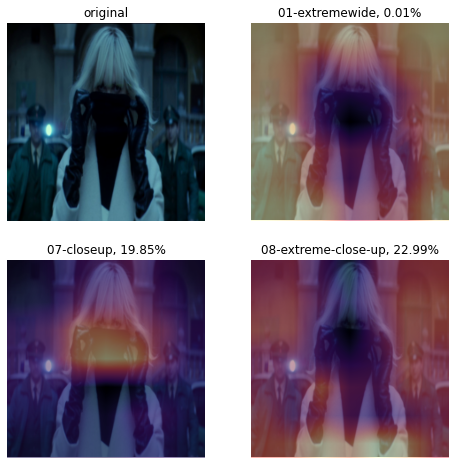

In [ ]:
gcam.plot(max_ncols=2, full_size=False, plot_original=True, alpha=0.5, figsize=(8,8))

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_interpret_classification-interpretation.ipynb.
Converted 02_interpret_compare-models.ipynb.
Converted 03_interpret_gradcam.ipynb.
Converted 04_inference_export-to-other-frameworks.ipynb.
Converted 05_augment_PIL-img_filters.ipynb.
Converted index.ipynb.
